Prediction Target: When will the case reach "Send For Credit Collection"?
 - Target Feature: time until completion ("Send For Credit Collection" is reached)

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pm4py
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

## Data Exploration and Preparation

Goals: 
- Learn about the event log in terms of features that we can use for the prediction task
- prepare the data in a way that it does not bias the prediction

In [13]:
data = pm4py.read_xes("data/Road_Traffic_Fine_Management_Process.xes")
display(data)

case_id_col = "case:concept:name"
activity_col = "concept:name"
timestamp_col = "time:timestamp"

data[timestamp_col] = pd.to_datetime(data[timestamp_col])


# Get unique cases
case_ids = data[case_id_col].unique()

# Split 80/20 by case
train_cases, test_cases = train_test_split(
    case_ids, 
    test_size=0.2, 
    random_state=42
)

# Create train and test logs
train_log = data[data[case_id_col].isin(train_cases)]
test_log = data[data[case_id_col].isin(test_cases)]

print(f"Train cases: {len(train_cases)}")
print(f"Test cases: {len(test_cases)}")

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.00,NaN,NaN,NaN,NaN
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.00,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,131.0,25,NIL,Create Fine,A,0.0,complete,2002-09-07 00:00:00+00:00,142.0,0.0,V9999,NaN,NaN,NaN,NaN,NaN
561466,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2002-10-25 00:00:00+00:00,NaN,NaN,V9999,15.16,NaN,NaN,NaN,NaN
561467,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2002-11-04 00:00:00+00:00,NaN,NaN,V9999,NaN,P,N,NaN,NaN
561468,262.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-01-03 00:00:00+00:00,NaN,NaN,V9999,NaN,NaN,NaN,NaN,NaN


Train cases: 120296
Test cases: 30074


## Prefix Extraction
Goal:
- Derive labeled prefixes for each trace in the log.
We want to make predictions on incomplete cases. Therefore, we need to learn from correlations between incomplete traces and our prediction target. 


In [14]:
from sys import prefix
# Try to use time to select prefixes!

def extract_prefixes_for_regression(log, prefix_length):
    """
    Extract prefixes and calculate time until 'Send for Credit Collection'
    """
    log = log.sort_values([case_id_col, timestamp_col])
    
    all_prefixes = []
    
    for case_id, group in log.groupby(case_id_col):
        for i in range(1,prefix_length + 1):
        # Skip if case is too short
            if len(group) < i:
                continue
        
            # Check if "Send for Credit Collection" exists in this case
            credit_collection_events = group[group[activity_col] == 'Send for Credit Collection']
        
            if len(credit_collection_events) == 0:
                # No credit collection event in this case
                continue
        
            # Get the timestamp when credit collection occurs
            credit_collection_time = credit_collection_events.iloc[0][timestamp_col]
        
            # Get prefix (first N events)
            prefix = group.iloc[:i].copy()
        
            # Time of last event in prefix
            prefix_end_time = prefix.iloc[-1][timestamp_col]
        
            # Check if credit collection happens after the prefix
            if credit_collection_time <= prefix_end_time:
                # Credit collection already happened in the prefix
                continue
        
            # Calculate target: time from end of prefix to credit collection (in days)
            time_to_credit_collection = (credit_collection_time - prefix_end_time).total_seconds() / (24 * 3600)
        
            # Add Features for absolute Time
            # Create feature row for this prefix
            features = {}
            features['case_id'] = case_id
            features['prefix_length'] = i
        
            # last state features
            last_event = prefix.iloc[-1]
            features['last_activity'] = last_event[activity_col]
            features['last_resource'] = last_event['org:resource']
    
            # static case attributes
            features['amount'] = prefix['amount'].iloc[0]
            features['points'] = prefix['points'].iloc[0]
            features['article'] = prefix['article'].iloc[0]
            features['vehicleClass'] = prefix['vehicleClass'].iloc[0]
        
            # aggregated features
            features['num_events'] = len(prefix)
            features['total_expense'] = prefix['expense'].sum()
        
            # Count specific activities
            features['num_send_fine'] = (prefix[activity_col] == 'Send Fine').sum()
            features['num_insert_fine_notification'] = (prefix[activity_col] == 'Insert Fine Notification').sum()
            features['num_add_penalty'] = (prefix[activity_col] == 'Add penalty').sum()
            features['has_payment'] = int('Payment' in prefix[activity_col].values)
            features['has_appeal'] = int('Appeal to Judge' in prefix[activity_col].values)
        
            # Resource diversity
            features['num_unique_resources'] = prefix['org:resource'].nunique()

            # Time-based features
            if 'Send Fine' in prefix[activity_col].values and 'Add penalty' in prefix[activity_col].values:
                fine_time = prefix[prefix[activity_col] == 'Send Fine'].iloc[0][timestamp_col]
                penalty_time = prefix[prefix[activity_col] == 'Add penalty'].iloc[0][timestamp_col]
                features['fine_to_penalty_delay'] = (penalty_time - fine_time).total_seconds() / (24 * 3600)
        
            # regression target
            features['time_to_credit_collection_days'] = time_to_credit_collection
        
            all_prefixes.append(features)
    
    return pd.DataFrame(all_prefixes)

In [15]:
# Choose prefix length
# Try prefixes up to a certain time threshold
PREFIX_LENGTH = 5

# Extract prefixes from train and test
train_data = extract_prefixes_for_regression(train_log, PREFIX_LENGTH)
test_data = extract_prefixes_for_regression(test_log, PREFIX_LENGTH)

print(f"\nTraining samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Check target distribution
print(f"\nTarget statistics (days until credit collection):")
print(train_data['time_to_credit_collection_days'].describe())

# Display first few rows
display(train_data.head())


Training samples: 190736
Test samples: 47847

Target statistics (days until credit collection):
count    190736.000000
mean        602.587687
std         201.731867
min          34.000000
25%         457.000000
50%         564.000000
75%         696.000000
max        3437.000000
Name: time_to_credit_collection_days, dtype: float64


,case_id,prefix_length,last_activity,last_resource,amount,points,article,vehicleClass,num_events,total_expense,num_send_fine,num_insert_fine_notification,num_add_penalty,has_payment,has_appeal,num_unique_resources,time_to_credit_collection_days,fine_to_penalty_delay
0,A100,1,Create Fine,561,35.0,0.0,157.0,A,1,0.0,0,0,0,0,0,1,971.0,NaN
1,A100,2,Send Fine,NaN,35.0,0.0,157.0,A,2,11.0,1,0,0,0,0,1,839.0,NaN
2,A100,3,Insert Fine Notification,NaN,35.0,0.0,157.0,A,3,11.0,1,1,0,0,0,1,805.0,NaN
3,A100,4,Add penalty,NaN,35.0,0.0,157.0,A,4,11.0,1,1,1,0,0,1,745.0,94.0
4,A10008,1,Create Fine,537,36.0,0.0,157.0,A,1,0.0,0,0,0,0,0,1,741.0,NaN


## Bucketing

## Feature Engineering & Encoding

In [16]:
# Separate features and target
feature_cols = [col for col in train_data.columns 
                if col not in ['case_id', 'time_to_credit_collection_days']]
categorical_cols = ['last_activity', 'last_resource', 'article', 'vehicleClass']

X_train = train_data[feature_cols]
y_train = train_data['time_to_credit_collection_days']

X_test = test_data[feature_cols]
y_test = test_data['time_to_credit_collection_days']

# One-hot encode categorical variables --> Necessary for RandomForest??
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols)

# Align columns
X_train_encoded, X_test_encoded = X_train_encoded.align(
    X_test_encoded, join='left', axis=1, fill_value=0
)

print(f"\nFeature matrix shape:")
print(f"Train: {X_train_encoded.shape}")
print(f"Test: {X_test_encoded.shape}")
display(X_train_encoded.head())


Feature matrix shape:
Train: (190736, 217)
Test: (47847, 217)


,prefix_length,amount,points,num_events,total_expense,num_send_fine,num_insert_fine_notification,num_add_penalty,has_payment,has_appeal,...,article_191.0,article_192.0,article_193.0,article_213.0,article_214.0,article_401.0,vehicleClass_A,vehicleClass_C,vehicleClass_M,vehicleClass_R
0,1,35.0,0.0,1,0.0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
1,2,35.0,0.0,2,11.0,1,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
2,3,35.0,0.0,3,11.0,1,1,0,0,0,...,False,False,False,False,False,False,True,False,False,False
3,4,35.0,0.0,4,11.0,1,1,1,0,0,...,False,False,False,False,False,False,True,False,False,False
4,1,36.0,0.0,1,0.0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False


## Model Building and Training



In [17]:
# Train regression model
reg = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
reg.fit(X_train_encoded, y_train)

# Predict
y_pred = reg.predict(X_test_encoded)

# Evaluate
print("\nRegression Model Performance:")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"R^2 Score: {r2:.3f}")

# Show some predictions vs actual
comparison = pd.DataFrame({
    'Actual_Days': y_test.values[:10],
    'Predicted_Days': y_pred[:10],
    'Error_Days': np.abs(y_test.values[:10] - y_pred[:10])
})
print("\nSample Predictions:")
print(comparison)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': reg.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Regression Model Performance:
Mean Absolute Error (MAE): 119.13 days
Root Mean Squared Error (RMSE): 165.19 days
R^2 Score: 0.314

Sample Predictions:
   Actual_Days  Predicted_Days  Error_Days
0        741.0      699.278660   41.721340
1        622.0      561.288185   60.711815
2        615.0      556.667543   58.332457
3        555.0      542.017043   12.982957
4        733.0      711.217418   21.782582
5        606.0      565.704074   40.295926
6        580.0      565.606889   14.393111
7        520.0      471.596628   48.403372
8        753.0      703.697270   49.302730
9        622.0      561.288185   60.711815

Top 10 Most Important Features:
                   feature  importance
1                   amount    0.493104
5            num_send_fine    0.193505
11   fine_to_penalty_delay    0.112562
4            total_expense    0.081351
2                   points    0.037097
195          article_157.0    0.009579
196          article_158.0    0.004443
10    num_unique_resources    

## Evaluation

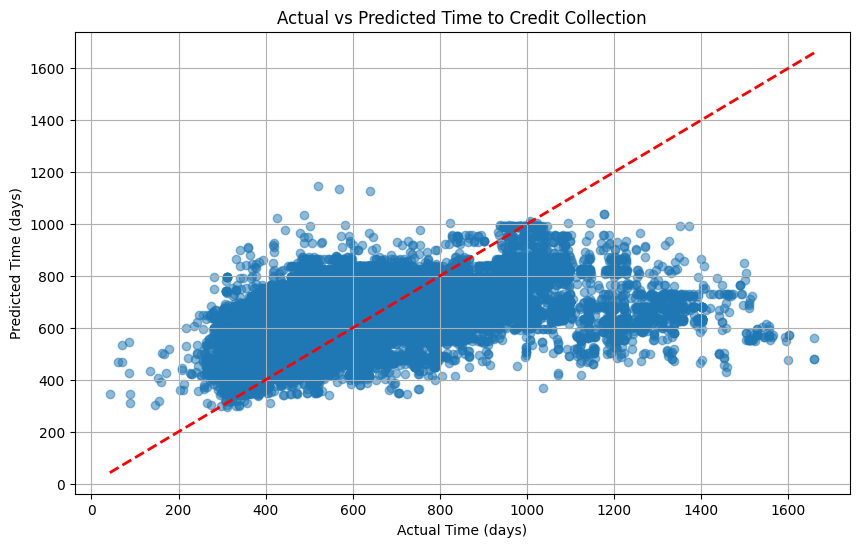

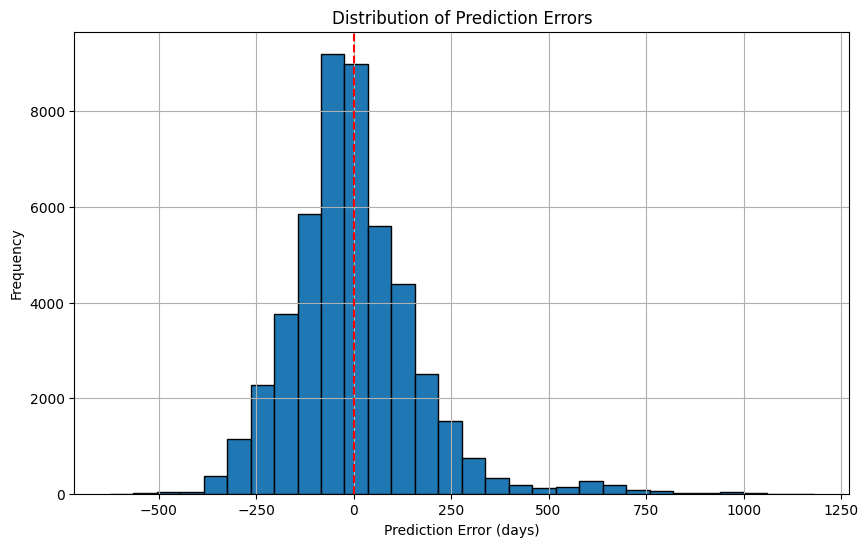

In [18]:
# Add Marginal Scatter Plots with Visualizations for each axis (see medium article) --> See where predictions land
# Check out how to render images on GitHub/Marimo (Screenshots)
# Complement Chart with Absolute Time


# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Time (days)')
plt.ylabel('Predicted Time (days)')
plt.title('Actual vs Predicted Time to Credit Collection')
plt.grid(True)
plt.show()

# Distribution of errors
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Error (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

## Interpretation